# Resnet Trained on Tumor and Healthy Images

This notebook should be run on Google Colab for faster training.


In [1]:
# import necessary libraries
import numpy as np
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from IPython.display import display
import zipfile
import io
from google.colab import files
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from collections import defaultdict
from IPython.display import display
import torchvision.datasets as datasets
import torch.optim as optim
import torchvision.models as models

In [2]:
! pip install git+https://github.com/davidbau/baukit
from baukit import TraceDict

  Cloning https://github.com/davidbau/baukit to /tmp/pip-req-build-ggl_g9ap
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit /tmp/pip-req-build-ggl_g9ap
  Resolved https://github.com/davidbau/baukit to commit 9d51abd51ebf29769aecc38c4cbef459b731a36e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cach

Define necessary functions

In [3]:
def plot_histograms(title, datalist):
    fig, axes = plt.subplots(len(datalist), 1, figsize=(10, 1.5 * len(datalist)), sharex=True)
    fig.suptitle(title)
    for i, (name, data) in enumerate(datalist):
        data_cpu = data.cpu().detach().numpy()
        axes[i].hist(data_cpu.flatten(), bins=100)
        axes[i].set_title(name)
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, loss_fn, optimizer, plot_grads=False):
    model.train()
    # initiate a loss monitor
    train_loss = []
    correct_predictions = 0

    for images, labels in train_loader:
        # predict the class
        images, labels = images.to(device), labels.to(device)
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # plot gradients
    if plot_grads:
        with TraceDict(model, [n for n, _ in model.named_modules() if 'conv' in n or 'lin' in n],
                    retain_grad=True) as trace:
            predicted = model(images[0:1])
            loss = loss_fn(predicted, labels[0:1])
            model.zero_grad()
            loss.backward()

        plot_histograms('Parameter gradients', [(n, p.grad)
            for n, p in model.named_parameters() if 'weight' in n])

        plot_histograms('Activations', [(n, trace[n].output)
            for n, p in model.named_modules() if 'lin' in n or 'conv' in n])

        plot_histograms('Activation gradients', [(n, trace[n].output.grad)
            for n, p in model.named_modules() if 'lin' in n or 'conv' in n])

    return np.mean(train_loss), correct_predictions / len(train_loader.dataset)

def evaluate_model(model, val_loader, loss_fn, device, return_confusion_matrix=False):
    model.eval()
    # Initiate a loss monitor
    val_loss = []
    true_labels = []
    predicted_labels = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)

        val_loss.append(loss.item())
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.argmax(dim=1).cpu().numpy())

    val_loss = np.mean(val_loss)
    val_acc = accuracy_score(true_labels, predicted_labels)
    val_precision = precision_score(true_labels, predicted_labels, average='micro')
    val_recall = recall_score(true_labels, predicted_labels, average='micro')

    if return_confusion_matrix:
        cm = confusion_matrix(true_labels, predicted_labels)
        return val_loss, val_acc, val_precision, val_recall, cm
    else:
        return val_loss, val_acc, val_precision, val_recall

def draw_confusion_matrix(confusion_matrix, val_set, labels, cmap="Blues"):
    confusion_matrix = np.array(confusion_matrix)
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    assert confusion_matrix.shape[0] == len(labels)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(confusion_matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(val_set.classes)), labels)
    ax.set_yticks(np.arange(len(val_set.classes)), labels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

    for true_label in range(len(val_set.classes)):
        for pred_label in range(len(val_set.classes)):
            ax.text(
                pred_label,
                true_label,
                int(confusion_matrix[true_label, pred_label]),
                ha="center",
                va="center",
                color="black",
            )

    fig.tight_layout()
    plt.show()

def find_image(model, true_class, predicted_class, test_loader):
    """ Prints an image with the given true label and prediction for the given model """
    # store images, true labels, and predicted labels for each class
    class_images = defaultdict(list)

    # get predictions
    for images, labels in test_loader:
        # Perform forward pass
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        # add each image to class images dict
        for image, true_label, predicted_label in zip(images, labels, predicted):
            class_images[true_label.item()].append((image, true_label.item(), predicted_label.item()))

    # find an image that matches the true class and predicted class
    found_image = False
    for image, true_label, predicted_label in class_images[true_class]:
        if true_label == true_class and predicted_label == predicted_class:
            tensor_to_pil = transforms.ToPILImage()
            pil_image = tensor_to_pil(image)
            display(pil_image.resize((256, 256)))
            print(f"True label: {true_label}")
            print(f"Predicted label: {predicted_label}")
            found_image = True
            break

    if not found_image:
        print("No image found matching the specified true class and predicted class.")

def visualize_con_layers_adjusted(model, device, test_data_loader):
    # get batch of images and labels
    images, labels = next(iter(test_data_loader))

    def get_activation(layer_name):
        def hook(model, input, output):
            activations[layer_name] = output.detach()
        return hook

    activations = {}
    model.conv1.register_forward_hook(get_activation('first_conv_layer'))
    model.conv2.register_forward_hook(get_activation('second_conv_layer'))
    model.conv3.register_forward_hook(get_activation('third_conv_layer'))

    # run a forward pass
    model.eval()
    with torch.no_grad():
        # Modify this line to ensure images are loaded to the appropriate device
        _ = model(images.to(device))  # Use .to(device) instead of explicitly .cuda()

    # extract the activation of the first image in the batch from the first conv layer
    first_image_features = activations['first_conv_layer'][0]
    second_image_features = activations['second_conv_layer'][0]
    third_image_features = activations['third_conv_layer'][0]
    images_features_lst = [first_image_features, second_image_features, third_image_features]

    # number of feature maps to display
    num_feature_maps_lst = [first_image_features.shape[0], second_image_features.shape[0], third_image_features.shape[0]]

    nth = {
        1: "First",
        2: "Second",
        3: "Third",
        # etc
    }

    for layer in range(len(num_feature_maps_lst)):

        fig, axes = plt.subplots(nrows=int(num_feature_maps_lst[layer]**0.5), ncols=int(num_feature_maps_lst[layer]**0.5), figsize=(12, 12))
        fig.suptitle(f'The {nth[layer+1]} Convolution Layer', fontsize=12)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Plot the feature map
            ax.imshow(images_features_lst[layer][i].cpu().numpy(), cmap='gray')
            ax.axis('off')  # Turn off axis
            if i >= num_feature_maps_lst[layer] - 1:
                break
        plt.show()

def visualize_con_layers_paper(model, device, test_data_loader):
    # get batch of images and labels
    images, labels = next(iter(test_data_loader))

    def get_activation(layer_name):
        def hook(model, input, output):
            activations[layer_name] = output.detach()
        return hook

    activations = {}
    model.conv1.register_forward_hook(get_activation('first_conv_layer'))
    model.conv2.register_forward_hook(get_activation('second_conv_layer'))

    # run a forward pass
    model.eval()
    with torch.no_grad():
        # Modify this line to ensure images are loaded to the appropriate device
        _ = model(images.to(device))  # Use .to(device) instead of explicitly .cuda()

    # extract the activation of the first image in the batch from the first conv layer
    first_image_features = activations['first_conv_layer'][0]
    second_image_features = activations['second_conv_layer'][0]
    images_features_lst = [first_image_features, second_image_features]

    # number of feature maps to display
    num_feature_maps_lst = [first_image_features.shape[0], second_image_features.shape[0]]

    nth = {
        1: "First",
        2: "Second",
    }

    for layer in range(len(num_feature_maps_lst)):

        fig, axes = plt.subplots(nrows=int(num_feature_maps_lst[layer]**0.5), ncols=int(num_feature_maps_lst[layer]**0.5), figsize=(12, 12))
        fig.suptitle(f'The {nth[layer+1]} Convolution Layer', fontsize=12)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Plot the feature map
            ax.imshow(images_features_lst[layer][i].cpu().numpy(), cmap='gray')
            ax.axis('off')  # Turn off axis
            if i >= num_feature_maps_lst[layer] - 1:
                break
        plt.show()

def plot_train_val_graphs(epochs, training_losses, training_accuracy, validation_losses, validation_accuracy):# Plotting training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), training_accuracy, label='Training Accuracy')
    plt.plot(range(1, epochs+1), validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


Upload Data

In [ ]:
# upload a folder from local machine
uploaded = files.upload()

for filename in uploaded.keys():
    with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as zip_ref:
        zip_ref.extractall('/content/google_colab_data')


Train and Evaluate Resnet50

In [17]:
# laod Resnet50
resnet50 = models.resnet50(pretrained=True)

# modify last layer to be 4 classes
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)

# load the data
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder('google_colab_data/balanced_unsized_data/tumor_healthy/train', transform=data_transform)
val_set = datasets.ImageFolder('google_colab_data/balanced_unsized_data/tumor_healthy/validation', transform=data_transform)
test_set = datasets.ImageFolder('google_colab_data/balanced_unsized_data/tumor_healthy/test', transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
resnet50.to(device)
epochs = 10
num_classes = len(train_set.classes)

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []

for epoch in range(epochs):
    plot_grads = True if epoch  == 9 else False
    train_loss, train_acc = train_model(resnet50, train_loader, loss_fn, optimizer, plot_grads)
    training_losses.append(train_loss)
    training_accuracy.append(train_acc)
    val_loss, val_acc, val_precision, val_recall = evaluate_model(resnet50, val_loader, loss_fn, device)
    validation_losses.append(val_loss)
    validation_accuracy.append(val_acc)
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f}"
    )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device: cuda
epoch: 1/10 | train loss=0.4592, train_acc=0.8202 | val loss: 0.2069, val_acc=0.9229
epoch: 2/10 | train loss=0.1055, train_acc=0.9616 | val loss: 0.2580, val_acc=0.9171
epoch: 3/10 | train loss=0.0547, train_acc=0.9820 | val loss: 0.7490, val_acc=0.7771
epoch: 4/10 | train loss=0.0303, train_acc=0.9924 | val loss: 0.3154, val_acc=0.8886
epoch: 5/10 | train loss=0.0708, train_acc=0.9779 | val loss: 0.3606, val_acc=0.8886
epoch: 6/10 | train loss=0.0232, train_acc=0.9924 | val loss: 0.2879, val_acc=0.8971
epoch: 7/10 | train loss=0.0100, train_acc=0.9977 | val loss: 0.4082, val_acc=0.9086
epoch: 8/10 | train loss=0.0104, train_acc=0.9977 | val loss: 0.4357, val_acc=0.8771
epoch: 9/10 | train loss=0.0337, train_acc=0.9884 | val loss: 0.3233, val_acc=0.9086
epoch: 10/10 | train loss=0.0304, train_acc=0.9913 | val loss: 0.2115, val_acc=0.9429


Test Loss: 0.21153889519750504, Test Accuracy: 0.9428571428571428, Test Precision: 0.9428571428571428, Test Recall: 0.9428571428571428


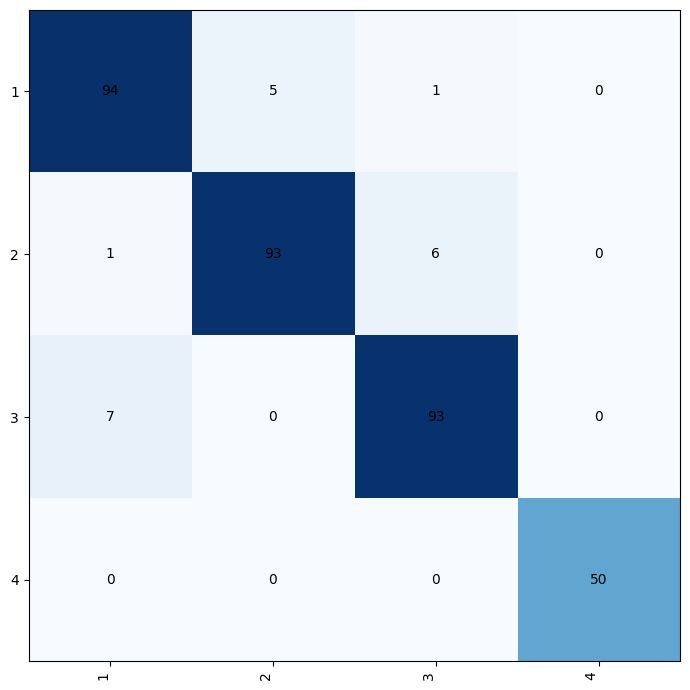

In [19]:
# get metrics and confusion matrix
test_loss, test_acc, test_precision, test_recall, test_confusion_matrix = evaluate_model(
    resnet50, test_loader, loss_fn, device, return_confusion_matrix=True
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}")
draw_confusion_matrix(test_confusion_matrix, val_set, train_set.classes)

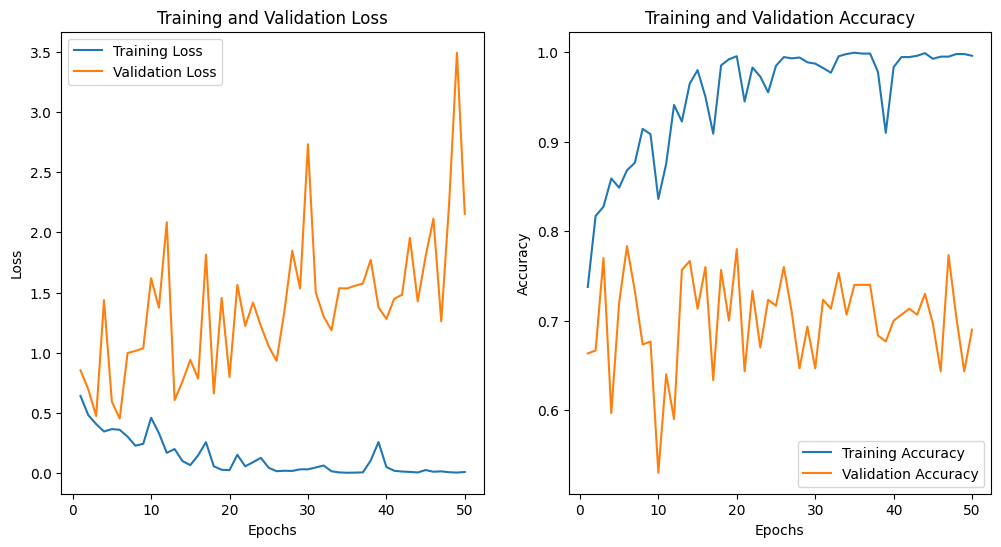

In [ ]:
# plot train and val loss
plot_train_val_graphs(epochs, training_losses, training_accuracy, validation_losses, validation_accuracy)

In [ ]:
# observere intermediate layer outputs
visualize_con_layers_adjusted(model, device, adj_test_loader)

NameError: name 'model' is not defined